



\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#
#     PART A Section III       # 
\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#
  


In [0]:
!pip install tensorflow
!pip install tensorflow-gpu

In [0]:
# Importation of libraries (incuding tensorflow)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# loadData is a function which load the dataset and split into training/test images and labels
def loadData():
  # import the Fashion MNIST dataset
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
  
  # The different types of classes in the dataset at their corresponding index emplacement.
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  
  number_of_classes = len(class_names)

  # the selected images (train and test) are normalized by dividing by 255.
  # since pixel values are between 0 to 255 
  train_images = train_images / 255.0
  test_images = test_images / 255.0
  
  # Shaping the train/test labels into an array of 1 row
  train_images = train_images.reshape(train_images.shape[0],-1)
  test_images = test_images.reshape(test_images.shape[0],-1)
  
  # Convert the integer labels into one hot encoded labels for training and test
  train_labels = tf.keras.utils.to_categorical(train_labels, number_of_classes)
  test_labels = tf.keras.utils.to_categorical(test_labels, number_of_classes)
  
  # Transpose train and test images to get a dimension as: classes * number of instances
  train_images = train_images.T
  test_images = test_images.T
  
  # Transpose train and test labels to get a dimension as: classes * number of instances
  train_labels = train_labels.T
  test_labels = test_labels.T
  
# returning the train/test images and labels
  return train_images, train_labels, test_images, test_labels



In [0]:
# neuron_layer is a function which describes the operation done at neuron level 
# for each feature with a specific weight W and bias b.
# A selection of the activation function is also done for for each neurons layer (Here either relu, sigmoid or softmax)
# The inputs are :
#   X = the input data to be processed
#   n_neuron = the number of neurons in the layer
#   name = the name of the layer
#   activation = the nactivation function to be inserted after the pre activation values (the activation function is optional)
# The output is the logits after activation (ar without activation)
def neuron_layer(X,n_neurons,name,activation=None):
  # A scope is created for each neurons layer.
  with tf.name_scope(name):
    # The matrix of weight for each feature is created and initialized
    W=tf.get_variable(name,[n_neurons, int(X.shape[0])],initializer= tf.glorot_uniform_initializer(seed=1))
    # The matrix of bias for each feature is created and initialized
    bias_name = name+"_bias"
    b=tf.Variable(tf.zeros([n_neurons,1]),name=bias_name)
    
    # we will mutliply each training data by the weights and add bias
    pred=tf.add(tf.matmul(W,X),b)
    
    # Pipe eventually the results through an activiation function (relu, sigmoid, softmax or none)
    if activation=="relu":
      return tf.nn.relu(pred)
    if activation=="sigmoid":
      return tf.sigmoid(pred)
    if activation=="softmax":
      return tf.nn.softmax(pred)
    else:
      return pred

In [0]:
# We reset all graph 
tf.reset_default_graph()

### Initial settings of the graph:
#    n_neurons_1: number of neurons at layer 1 
#    n_neurons_2: number of neurons at layer 2 
#    n_neurons_3: number of neurons at layer 3 
#    n_classes: number of classes to be sorted 
#    learning_rate:  Learning rate for the Gradient Descent algorithm 
#    num_epochs:  Number of iterations to be performed to run the Gradient Descent algorithm 
n_neurons_1 = 300
n_neurons_2 = 100
n_neurons_3 = 10
n_classes = 10
learning_rate = 0.01
num_epochs = 40



### Construction of the graph:

# Image and Test data/labels are loaded with the loadData function (see the loadData function)
tr_x, tr_y, te_x, te_y = loadData()

# Placeholder construction: we specify the shape of the training/test images (X) and labels (y)
# Number of column in the placeholder is None (unspecified) since number of instances may vary between training and test data
X = tf.placeholder(tf.float32,[tr_x.shape[0],None],name="X")
y = tf.placeholder(tf.float32,[n_classes,None],name="y")

# Neuronal Network construction and scope
with tf.name_scope("neuronal_net"):
  # 1st layer of neurons taking the data as input, with 300 neurons and with the relu activation function
  layer1 = neuron_layer(X,n_neurons_1,"layer1",activation="relu")
  # 2nd layer of neurons taking the data as input, with 100 neurons and with the relu activation function
  layer2 = neuron_layer(layer1,n_neurons_2,"layer2",activation="relu")
  # logits is the neurons layer taking the 2nd layer output as input, with 10 neurons and with the softmax activation function
  logits = neuron_layer(layer2,n_neurons_3,"layer3",activation="softmax")
  # 3rd layer is the data after the 2nd layer without activation function and which will be used for the cross entropy calculation
  layer3 = neuron_layer(layer2,n_classes,"out")

  # Transpose the train and label data again to revert back to 
  # shape number of instances * number of classes
  layer3_T = tf.transpose(layer3)
  logits_T = tf.transpose(logits)
  labels = tf.transpose(y)

# Loss/cross entropy calculation construction and scope
with tf.name_scope("loss"):
  # Calculate the cross entropy error for all training data
  x_entropy= tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer3_T, labels=labels)
  # Calculate the mean cross entropy error
  loss=tf.reduce_mean(x_entropy,name="avg_xentropy")

# Training construction and scope  
with tf.name_scope("train"):    
  # The Gradient Decent is used as our training model. The aim is to minimize the cross entropy mean error
  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Accuracy calculation and scope  
with tf.name_scope("accuracy"): 
  # select the class with the highest value
  predictions = tf.argmax(layer3)
  # Check if the model prediction is correct (True if prediction correct, False otherwise)
  correct = tf.equal(predictions, tf.argmax(y))
  # Conversion of the boolean array into a numerical array (1 if True, 0 if False)
  pred_correct = tf.cast(correct,tf.float32)
  # mean value of predictions_correct
  accuracy = tf.reduce_mean(pred_correct)


In [0]:
from numpy import random

# get_mini_batches is a function which splits the training data (images and labels) 
# given a batch size in order to train individually each batch
# and accelerates the training process 
def get_mini_batches(X, y, batch_size, shuffle=False):
    # batch shuffle selection 
    if shuffle:
      # shuffle batch selection (by returning ranon indexes) if activated
      random_idxs = random.choice(int(y.shape[1]), int(y.shape[1]), replace=False)
    else:
      # unshuflled batch selection
      random_idxs = np.arange(int(y.shape[1]))

    # construction of the mini batches by returning array of images/labels batches 
    X_shuffled = X[:,random_idxs]
    y_shuffled = y[:,random_idxs]
    mini_batches = [(X_shuffled[:,i:i+batch_size], y_shuffled[:,i:i+batch_size]) for
                   i in range(0, int(y.shape[1]), batch_size)]
    # return mini batches
    return mini_batches

Iteration:  0  Average Loss:  0.9437971310814222  Average Accuracy:  0.7090999995420376
Iteration:  10  Average Loss:  0.3679398946960767  Average Accuracy:  0.8744833333293597
Iteration:  20  Average Loss:  0.31636013781030975  Average Accuracy:  0.8919500013192495
Iteration:  30  Average Loss:  0.28253865177432697  Average Accuracy:  0.9025333355863889
Final Training Accuracy: 0.90
Final Test Accuracy: 0.88
Training Model run Time: 92.2 s.


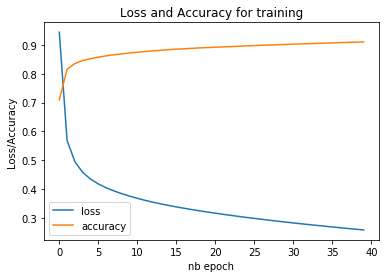

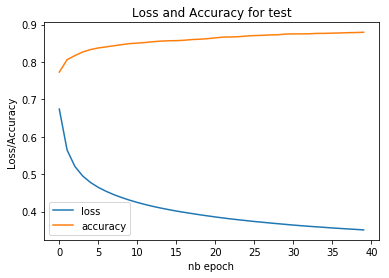

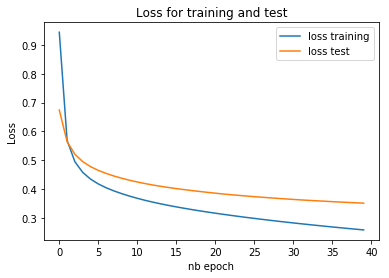

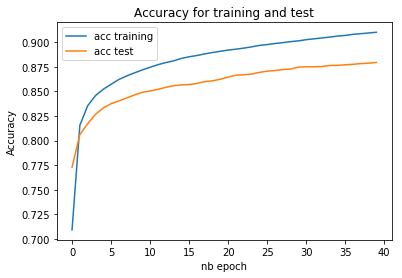

In [0]:
# Display of the training result according to the number of step
display_step = 10
batch_size = 100

# Array to store result of loss and accuracy depending of the epoch iteration for train and test data
epoch_result_train = []
epoch_result_test = []

import timeit
### Start training session 
with tf.Session() as sess:
  # store the start timing of the model training 
  start = timeit.default_timer() 
  # Initialize all variables
  sess.run(tf.global_variables_initializer())
  # contruction of the mini batches
  mini_batches = get_mini_batches(tr_x,tr_y, batch_size)
  
  # Iterate num_epoch times the training process using the gradient descent optimize
  for epoch in range(num_epochs):
    # initialization of variable to calculate the total losses and accuracy in mini batches
    batch_step = 0
    total_loss = 0 
    total_accuracy = 0
    # training iteration for each mini batches
    for X_batch, Y_batch in mini_batches:
      # Run the mini batch session
      sess.run(train_step, feed_dict={X:X_batch, y:Y_batch})
      # current loss and accuracy for training
      acc,l=sess.run([accuracy,loss],feed_dict={X:X_batch, y:Y_batch})
      # batch step, total loss and total average caculation
      batch_step+=1
      total_loss += l
      total_accuracy += acc
    
    # training Average loss and accuracy for each epoch
    avg_loss = total_loss/batch_step
    avg_acc = total_accuracy/batch_step
    epoch_result_train.append([epoch, avg_loss, avg_acc])
    
    # test loss and accuracy for each epoch
    acc_te,l_te=sess.run([accuracy,loss],feed_dict={X:te_x, y:te_y})
    epoch_result_test.append([epoch, l_te, acc_te])
    
    # Display average loss and accuracy for training
    if epoch% display_step== 0:
      print('Iteration: ', epoch,' Average Loss: ', avg_loss, ' Average Accuracy: ', avg_acc)

  # Print final Training and test accuracy    
  print("Final Training Accuracy: {:.2f}".format(accuracy.eval({X: tr_x, y: tr_y})))
  print("Final Test Accuracy: {:.2f}".format(accuracy.eval({X: te_x, y: te_y})))
  # store the stop timing of the model training
  stop = timeit.default_timer()
  print('Training Model run Time: {:.1f} s.'.format(stop - start))

  # Plot Loss and Accuracy for training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,1].astype(float), label='loss')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,2].astype(float), label='accuracy')
  plt.title('Loss and Accuracy for training')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss/Accuracy')
  ax.legend()
  plt.show()

  
  # Plot Loss and Accuracy for test
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,1].astype(float), label='loss')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,2].astype(float), label='accuracy')
  plt.title('Loss and Accuracy for test')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss/Accuracy')
  ax.legend()
  plt.show()
  
  # Plot Loss for test and training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,1].astype(float), label='loss training')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,1].astype(float), label='loss test')
  plt.title('Loss for training and test')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss')
  ax.legend()
  plt.show()
  
  # Plot Accuracy for test and training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,2].astype(float), label='acc training')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,2].astype(float), label='acc test')
  plt.title('Accuracy for training and test')
  plt.xlabel('nb epoch')
  plt.ylabel('Accuracy')
  ax.legend()
  plt.show()


Iteration:  0  Average Loss:  1.5716949214537939  Average Accuracy:  0.5349166689751049
Iteration:  10  Average Loss:  0.5267246440052986  Average Accuracy:  0.8254666666189829
Iteration:  20  Average Loss:  0.45524010981122653  Average Accuracy:  0.8449499984582265
Iteration:  30  Average Loss:  0.4220068243642648  Average Accuracy:  0.8561333308617274
Final Training Accuracy: 0.86
Final Test Accuracy: 0.84
Training Model run Time: 36.6 s.


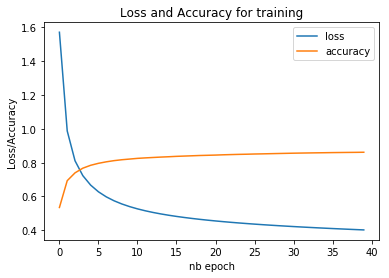

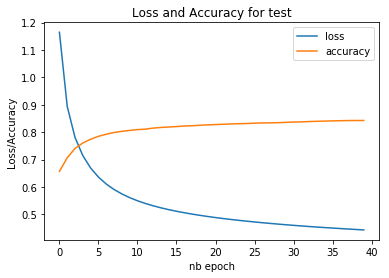

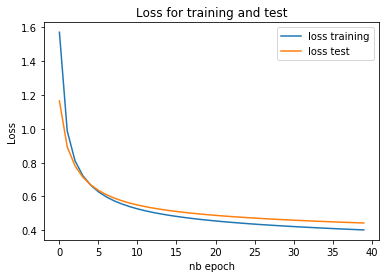

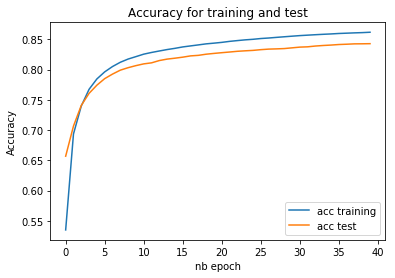

In [0]:
# Display of the training result according to the number of step
display_step = 10
batch_size = 500

# Array to store result of loss and accuracy depending of the epoch iteration for train and test data
epoch_result_train = []
epoch_result_test = []

### Start training session 
with tf.Session() as sess:
  # store the start timing of the model training 
  start = timeit.default_timer() 
  # Initialize all variables
  sess.run(tf.global_variables_initializer())
  # contruction of the mini batches
  mini_batches = get_mini_batches(tr_x,tr_y, batch_size)
  
  # Iterate num_epoch times the training process using the gradient descent optimize
  for epoch in range(num_epochs):
    # initialization of variable to calculate the total losses and accuracy in mini batches
    batch_step = 0
    total_loss = 0 
    total_accuracy = 0
    # training iteration for each mini batches
    for X_batch, Y_batch in mini_batches:
      # Run the mini batch session
      sess.run(train_step, feed_dict={X:X_batch, y:Y_batch})
      # current loss and accuracy for training
      acc,l=sess.run([accuracy,loss],feed_dict={X:X_batch, y:Y_batch})
      # batch step, total loss and total average caculation
      batch_step+=1
      total_loss += l
      total_accuracy += acc
    
    # training Average loss and accuracy for each epoch
    avg_loss = total_loss/batch_step
    avg_acc = total_accuracy/batch_step
    epoch_result_train.append([epoch, avg_loss, avg_acc])
    
    # test loss and accuracy for each epoch
    acc_te,l_te=sess.run([accuracy,loss],feed_dict={X:te_x, y:te_y})
    epoch_result_test.append([epoch, l_te, acc_te])
    
    # Display average loss and accuracy for training
    if epoch% display_step== 0:
      print('Iteration: ', epoch,' Average Loss: ', avg_loss, ' Average Accuracy: ', avg_acc)

      
  print("Final Training Accuracy: {:.2f}".format(accuracy.eval({X: tr_x, y: tr_y})))
  print("Final Test Accuracy: {:.2f}".format(accuracy.eval({X: te_x, y: te_y})))
  # store the stop timing of the model training
  stop = timeit.default_timer()
  print('Training Model run Time: {:.1f} s.'.format(stop - start))

  # Plot Loss and Accuracy for training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,1].astype(float), label='loss')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,2].astype(float), label='accuracy')
  plt.title('Loss and Accuracy for training')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss/Accuracy')
  ax.legend()
  plt.show()

  
  # Plot Loss and Accuracy for test
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,1].astype(float), label='loss')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,2].astype(float), label='accuracy')
  plt.title('Loss and Accuracy for test')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss/Accuracy')
  ax.legend()
  plt.show()
  
  # Plot Loss for test and training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,1].astype(float), label='loss training')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,1].astype(float), label='loss test')
  plt.title('Loss for training and test')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss')
  ax.legend()
  plt.show()
  
  # Plot Accuracy for test and training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,2].astype(float), label='acc training')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,2].astype(float), label='acc test')
  plt.title('Accuracy for training and test')
  plt.xlabel('nb epoch')
  plt.ylabel('Accuracy')
  ax.legend()
  plt.show()


Iteration:  0  Average Loss:  1.8429925739765167  Average Accuracy:  0.42588333201905093
Iteration:  10  Average Loss:  0.6377396672964096  Average Accuracy:  0.7925666650136312
Iteration:  20  Average Loss:  0.5314191107948621  Average Accuracy:  0.8240500032901764
Iteration:  30  Average Loss:  0.48540417303641636  Average Accuracy:  0.8356833318869273
Final Training Accuracy: 0.84
Final Test Accuracy: 0.83
Training Model run Time: 27.8 s.


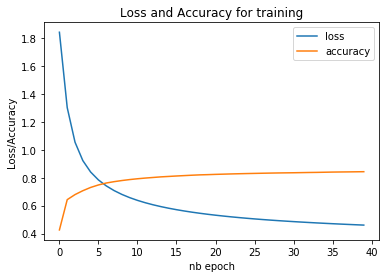

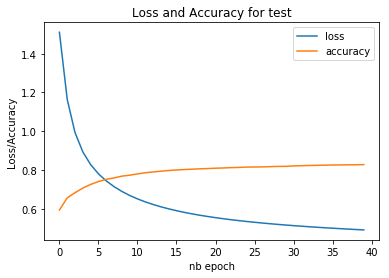

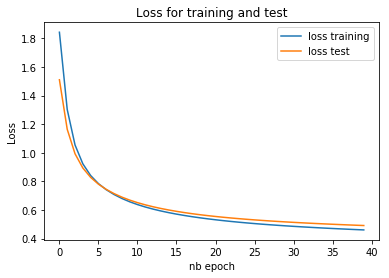

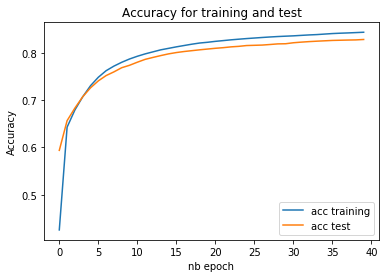

In [0]:
# Display of the training result according to the number of step
display_step = 10
batch_size = 1000

# Array to store result of loss and accuracy depending of the epoch iteration for train and test data
epoch_result_train = []
epoch_result_test = []

### Start training session 
with tf.Session() as sess:
  # store the start timing of the model training 
  start = timeit.default_timer() 
  # Initialize all variables
  sess.run(tf.global_variables_initializer())
  # contruction of the mini batches
  mini_batches = get_mini_batches(tr_x,tr_y, batch_size)
  
  # Iterate num_epoch times the training process using the gradient descent optimize
  for epoch in range(num_epochs):
    # initialization of variable to calculate the total losses and accuracy in mini batches
    batch_step = 0
    total_loss = 0 
    total_accuracy = 0
    # training iteration for each mini batches
    for X_batch, Y_batch in mini_batches:
      # Run the mini batch session
      sess.run(train_step, feed_dict={X:X_batch, y:Y_batch})
      # current loss and accuracy for training
      acc,l=sess.run([accuracy,loss],feed_dict={X:X_batch, y:Y_batch})
      # batch step, total loss and total average caculation
      batch_step+=1
      total_loss += l
      total_accuracy += acc
    
    # training Average loss and accuracy for each epoch
    avg_loss = total_loss/batch_step
    avg_acc = total_accuracy/batch_step
    epoch_result_train.append([epoch, avg_loss, avg_acc])
    
    # test loss and accuracy for each epoch
    acc_te,l_te=sess.run([accuracy,loss],feed_dict={X:te_x, y:te_y})
    epoch_result_test.append([epoch, l_te, acc_te])
    
    # Display average loss and accuracy for training
    if epoch% display_step== 0:
      print('Iteration: ', epoch,' Average Loss: ', avg_loss, ' Average Accuracy: ', avg_acc)

      
  print("Final Training Accuracy: {:.2f}".format(accuracy.eval({X: tr_x, y: tr_y})))
  print("Final Test Accuracy: {:.2f}".format(accuracy.eval({X: te_x, y: te_y})))
  # store the stop timing of the model training
  stop = timeit.default_timer()
  print('Training Model run Time: {:.1f} s.'.format(stop - start))

  # Plot Loss and Accuracy for training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,1].astype(float), label='loss')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,2].astype(float), label='accuracy')
  plt.title('Loss and Accuracy for training')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss/Accuracy')
  ax.legend()
  plt.show()

  
  # Plot Loss and Accuracy for test
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,1].astype(float), label='loss')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,2].astype(float), label='accuracy')
  plt.title('Loss and Accuracy for test')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss/Accuracy')
  ax.legend()
  plt.show()
  
  # Plot Loss for test and training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,1].astype(float), label='loss training')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,1].astype(float), label='loss test')
  plt.title('Loss for training and test')
  plt.xlabel('nb epoch')
  plt.ylabel('Loss')
  ax.legend()
  plt.show()
  
  # Plot Accuracy for test and training
  fig, ax = plt.subplots()
  ax.plot(np.arange(num_epochs), np.array(epoch_result_train)[:,2].astype(float), label='acc training')
  ax.plot(np.arange(num_epochs), np.array(epoch_result_test)[:,2].astype(float), label='acc test')
  plt.title('Accuracy for training and test')
  plt.xlabel('nb epoch')
  plt.ylabel('Accuracy')
  ax.legend()
  plt.show()
